In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import scipy.optimize as opt
from scipy.optimize import curve_fit
import spinmob as s
import matplotlib.pylab as pylab

# import os 
# os.chdir('C:\\Users\\joeyb\\Documents\\Physics 359\\Hall')

In [3]:
def linear(V, m, b):
    return m*V + b

In [4]:
mv = (np.loadtxt('all_the_mv.csv', delimiter=',', skiprows = 1))

In [5]:
result = []
for sublist in mv:
    for item in sublist:
        result.append(item)
#print("\nCollapse nested lists:")
final_result = np.transpose(result)
# print(final_result)

TempArray = np.linspace(-270, 399, 670)

### Temp vs Voltage

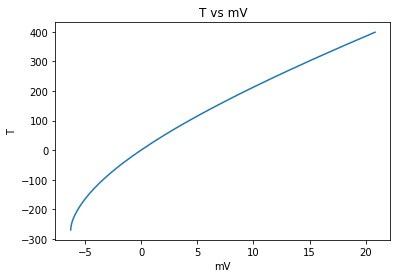

In [6]:
plt.plot(final_result, TempArray)
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.show()

### Trying with just taking linear approx on small scales

In [7]:
#splitting arrays in to 10 element arrays
mVArraysOf10 = np.split(final_result, len(final_result)/10)
TArraysOf10 = np.split(TempArray, len(final_result)/10)

for i in range(0, len(mVArraysOf10)):
    if (i != len(mVArraysOf10) - 1):
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i+1][0])
        TArraysOf10[i] = np.append(TArraysOf10[i], TArraysOf10[i+1][0])

    else:
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i-1][-1])
        TArraysOf10[i]= np.append(TArraysOf10[i], TArraysOf10[i-1][-1])


#get linear fit for each array of 10
fits = []

for i in range(0, int(len(final_result)/10)):
    popt, pcov = curve_fit(linear, mVArraysOf10[i], TArraysOf10[i])
    fits.append([popt, np.sqrt(np.diag(pcov))])
    
# print(fits[-1])
# perr = np.sqrt(np.diag(fits[0][0]))
# print(perr)

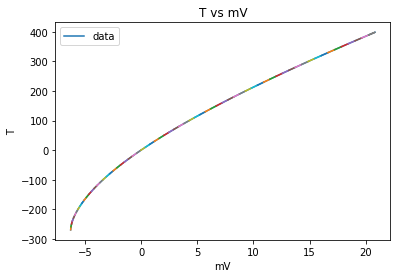

In [8]:
#plotting fits to make sure they match the data

plt.plot(final_result, TempArray, label="data")
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.legend()

for i in range(0, len(fits)):
    plt.plot(mVArraysOf10[i], linear(mVArraysOf10[i], fits[i][0][0], fits[i][0][1]))

plt.show()

## Errors
#### From Temp calibration  
LIMITS OF ERROR (whichever is greater)			
Standard	1.0Â°C or 0.75% Above 0Â°C	 1.0Â°C or 1.5% Below 0Â°C	
Special	0.5Â°C or 0.4%		
lets go with 1 degree for now

#### Model 199 DMM
0.0012(value) + 3^3 in last digit

In [9]:

"""
Takes input voltage (mV) and outputs corresponding temperature (C)
Must be run with mVArraysOf10[] and fits[]
Need errors


"""
def getTempFromVolt(V):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1])
            fitted = True

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            break
    
    return TempVal

def linearErr(V, erV, m, erM, b, erb):
    return np.sqrt( (m*V)**2*( (erM/m)**2+ (erV/V)**2) + (erb)**2 )

"""
Takes in a voltage and it's error.
Returns an array of the corresponding temp in kelvin and it's error
"""
def getTempFromVolt_Err(V, ErrV):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1]) + 273.15
            fitted = True
            
            Err = linearErr(V, ErrV, fits[index][0][0], fits[index][1][0], fits[index][0][1], fits[index][1][1])
            #need to get errors
#             fits[index][1][0], fits[index][1][1] + error on V

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            Err = 0
            break
    
    return [TempVal, Err]

In [10]:
# Use function to get temp for a given V
V = 3.34
VoltErr = 0.012*V + 3**3*(1e-7) #this is sorta for the wrong range

Temp = getTempFromVolt_Err(V, VoltErr)
            
print("%f (%f) K" %(Temp[0], Temp[1]))

352.773115 (0.901821) K


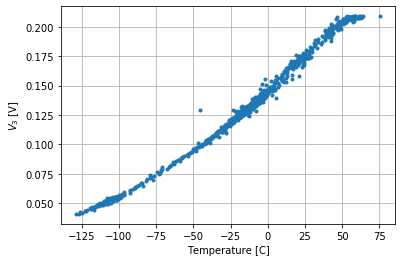

In [11]:
#plotting V4 vs temp to get big resistance as V=IR 

dataLower = np.transpose((np.loadtxt('Data/2020-02-10 13_41 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))
tempDataLower = [getTempFromVolt(V) for V in dataLower[7]*1e3]

plt.plot(tempDataLower, dataLower[2], ls=" ", marker=".")

plt.grid()
plt.ylabel("$V_3$ [V]")
plt.xlabel("Temperature [C]")

plt.show()

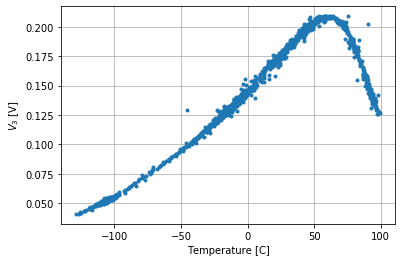

In [12]:
dataHigher = np.transpose((np.loadtxt('Data/2020-02-12 15_09 Voltage Readings Data_full.csv', delimiter=',', skiprows = 1)))

tempDataHigher = [getTempFromVolt(V) for V in dataHigher[7]*1e3]

TempDataCom = tempDataLower + tempDataHigher
DataCom = np.concatenate((dataLower, dataHigher), axis=1)

plt.plot(TempDataCom, DataCom[2], ls=" ", marker=".")

plt.grid()
plt.ylabel("$V_3$ [V]")
plt.xlabel("Temperature [C]")

plt.show()

## Fits

-0.0010824
-1.0288800000000002e-05


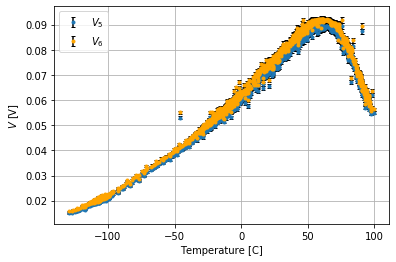

In [13]:
TempDataCom = tempDataLower + tempDataHigher

DataCom = np.concatenate((dataLower, dataHigher), axis=1)

print(DataCom[0][0])

DataCom_Err = []
errStatic = 3**3*(1e-7)

for row in DataCom:
    row_err = []
    for ele in row:
#         print(ele)
        row_err.append(0.012*ele + errStatic) 
        
    DataCom_Err.append(row_err)
    
print(DataCom_Err[0][0])

plt.errorbar(TempDataCom, DataCom[4], yerr=DataCom_Err[4], ls=" ", marker=".", label="$V_5$", ecolor='black', capsize=2)
plt.errorbar(TempDataCom, DataCom[5], yerr=DataCom_Err[5], ls=" ", marker=".", label="$V_6$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [C]")
plt.legend()

plt.show()

In [55]:
ele = 1.60217662e-19 #C
k = 8.617333262145e-5 #eV/K

V6_len = 4.800e-3 #in m, (0.002) mm
V5_len = 5.360e-3 #in m, (0.002) mm

gamma = 1e-3*V5_len / ( 0.91e-3*2.7e-3 ) #IL/A

def voltage_EgapCompl(T, Eg, Chp, power, C):
    term1 = Chp*T**(-power)
    term2 = np.exp(-Eg/(2*k*T))*(C)
    
    return gamma/ele * 1/(term1+term2)

# Ch         = 6.249e+25
#   power      = 2.2334 +/- 0.0015

def voltage_Egap(T, Eg, C):
    term1 = T**(2.23)/6.249e+25
    term2 = np.exp(Eg/(2*k*T))/C
    
    return (gamma/ele)*(1/term1+1/term2)**(-1)

# def voltage_Egap(T, Eg, gamma, C, A):
#     term1 = gamma*T**(-3/2)
#     term2 = np.exp(-Eg/(2*k*T))*C
    
#     return A/(term1+term2)

def voltage_low(T, Ch, power):
    term1 = T**(power)/Ch
    
    return (gamma/ele)*(term1)

def voltage_high(T, Eg, C):
    term2 = np.exp(Eg/(2*k*(T)))/(C)
    
    return (gamma/ele)*(term2)

In [15]:
# TempDataComK = [t + 273.15 for t in TempDataCom]
# TempDataComK = np.array(TempDataComK)

# # plt.plot(TempDataComK, voltage_Egap(TempDataComK, 0.7, 1, 1, 100), ls=" ", marker=".", label="$fit$")
# plt.plot(TempDataComK, voltage_low(TempDataComK, 0.7, 1e23), ls=" ", marker=".", label="$low$")
# # plt.plot(TempDataComK, voltage_high(TempDataComK, 0.7, 1, 1), ls=" ", marker=".", label="$high$")

# # plt.plot(TempDataCom, DataCom[4], ls=" ", marker=".", label="$V_5$")

# plt.grid()
# plt.ylabel("$V$ [V]")
# plt.xlabel("Temperature [K]")
# plt.legend()

# plt.show()
# # print(len(DataCom))

In [16]:
#sorting data in order of Temp
DataComS = DataCom
DataComS = np.transpose(DataCom)

index = DataComS[: , -1].argsort()
DataComSorted = []

for i in range(0, len(index)):
    DataComSorted.append(DataComS[index[i]])

In [17]:
DataComSORT = np.transpose(DataComSorted)

DataCom_Err = []
errStatic = 3**3*(1e-7)

for row in DataComSORT:
    row_err = []
    for ele in row:
        row_err.append(0.012*ele + errStatic) 
#     print(len(row_err))

    DataCom_Err.append(row_err)
    
DataCom_Err = np.array(DataCom_Err)

TempDataComErr = [getTempFromVolt_Err(DataComSORT[7][i]*1e3, DataCom_Err[7][i]*1e3) for i in range(0, len(DataComSORT[0])) ]
TempDataComErr = np.transpose(TempDataComErr)

# TempDataComSORT = [getTempFromVolt(V) for V in DataComSORT[7]*1e3]
# TempDataComKSORT = [t + 273.15 for t in TempDataComSORT]
TempDataComKSORT = np.array(TempDataComErr)

# print(len(DataCom_Err))

Peak split value:[334.61331145   0.75726468]


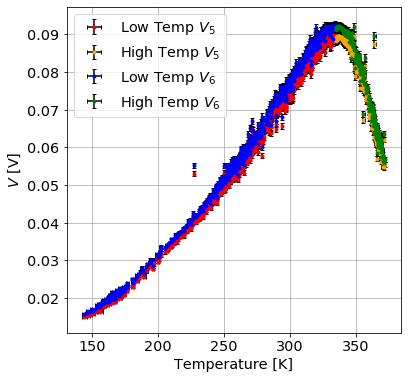

In [18]:
peak = np.where(DataComSORT == np.amax(DataComSORT))[1][0]
# print(peak)
print("Peak split value:" + str(TempDataComKSORT[:,peak]))

DataComLow = DataComSORT[:,0:peak]
TempDataComLow = TempDataComKSORT[:,0:peak]
DataCom_ErrLow = DataCom_Err[:, 0:peak]

DataComHigh = DataComSORT[:,peak:-1]
TempDataComHigh = TempDataComKSORT[:,peak:-1]
DataCom_ErrHigh = DataCom_Err[:, peak:-1]

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.errorbar(TempDataComLow[0], DataComLow[4], yerr=DataCom_ErrLow[4], xerr=TempDataComLow[1], ls=" ", marker=".", label="Low Temp $V_5$", ecolor='black', capsize=2, color="red")
plt.errorbar(TempDataComHigh[0], DataComHigh[4], yerr=DataCom_ErrHigh[4], xerr=TempDataComHigh[1], ls=" ", marker=".", label="High Temp $V_5$", ecolor='black', capsize=2, color="orange")

plt.errorbar(TempDataComLow[0], DataComLow[5], yerr=DataCom_ErrLow[5], xerr=TempDataComLow[1], ls=" ", marker=".", label="Low Temp $V_6$", ecolor='black', capsize=2, color="blue")
plt.errorbar(TempDataComHigh[0], DataComHigh[5], yerr=DataCom_ErrHigh[5], xerr=TempDataComHigh[1], ls=" ", marker=".", label="High Temp $V_6$", ecolor='black', capsize=2, color="green")


plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()

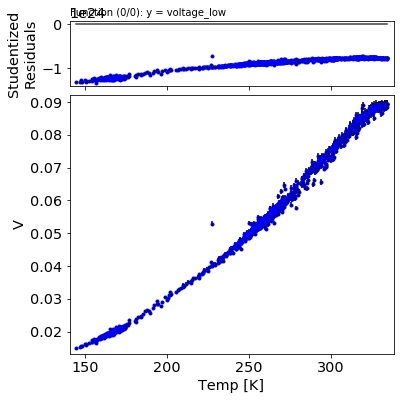

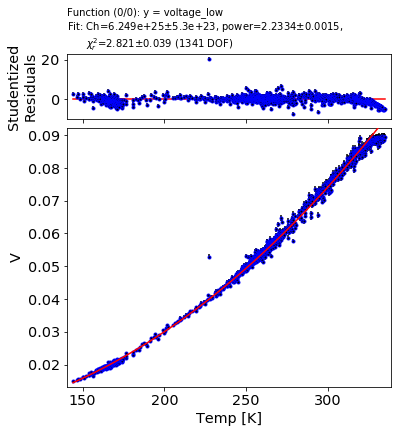

In [58]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")

guess='Ch=1e2, power=1.5'
my_fitter.set_functions(f=voltage_low, p=guess)

my_fitter.set_data(xdata=TempDataComLow[0], ydata=DataComLow[4], eydata=DataCom_ErrLow[4])
my_fitter.fit()
print()

In [33]:
# my_fitter = s.data.fitter()
# my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
#               , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# # help(s.data.fitter)

# guess='Eg=0.4, C=1e10'
# # guess=' Eg=.4, C=1e23, Ch=1e23, power=1.5'

# my_fitter.set_functions(f=voltage_high, p=guess)

# my_fitter.set_data(xdata=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:], eydata=DataCom_ErrHigh[4][100:])
# # my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

# my_fitter.fit()
# print()

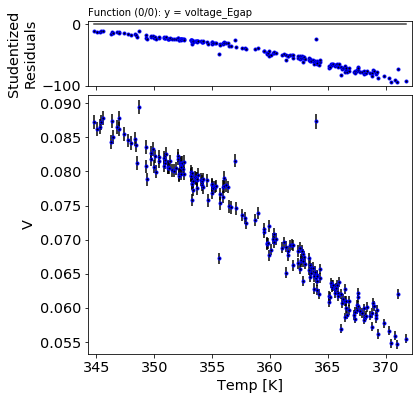

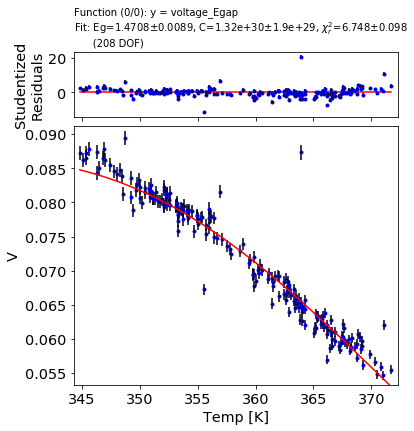

In [57]:
# voltage_Egap(T, Eg, C)
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# help(s.data.fitter)

guess='Eg=0.4, C=1e20'
# guess=' Eg=.4, C=1e23, Ch=1e23, power=1.5'

my_fitter.set_functions(f=voltage_Egap, p=guess)

my_fitter.set_data(xdata=TempDataComHigh[0][80:], ydata=DataComHigh[4][80:], eydata=DataCom_ErrHigh[4][80:])
# my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

my_fitter.fit()
print()

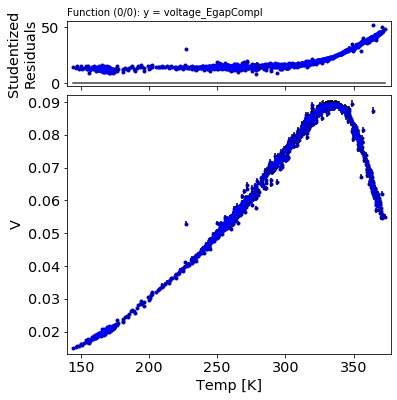

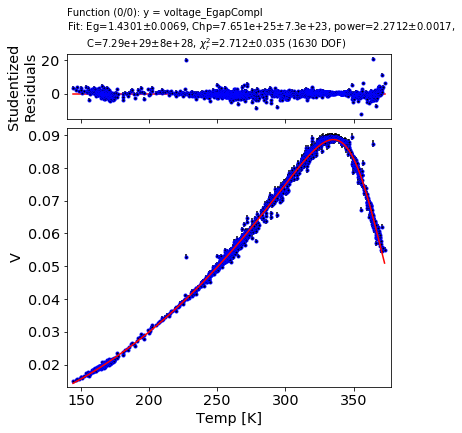

In [56]:
# voltage_EgapCompl(T, Eg, Ch, power, p, C):
    
#     DataComSORT
# TempDataComKSORT
# DataCom_Err

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# help(s.data.fitter)

guess='Eg=1.4, Chp=6.249e25, power=2.2, C=1.32e30'

my_fitter.set_functions(f=voltage_EgapCompl, p=guess)

my_fitter.set_data(xdata=TempDataComKSORT[0], ydata=DataComSORT[4], eydata=DataCom_Err[4])
# my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

my_fitter.fit()
print()

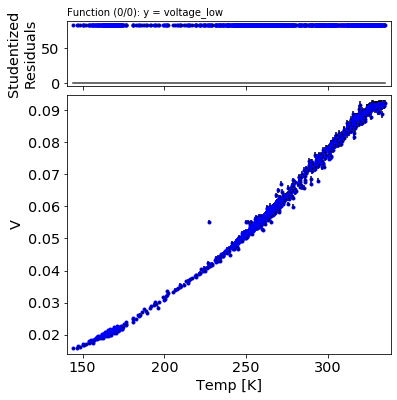

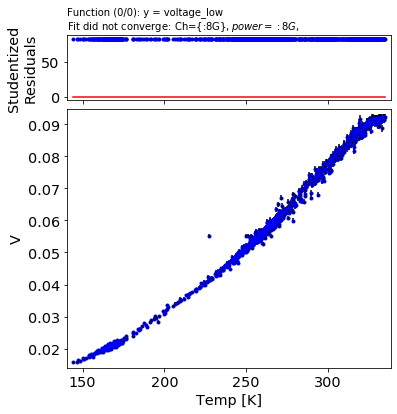

In [21]:
## V6 fits

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")

guess='Ch=1e24, power=1.5'
my_fitter.set_functions(f=voltage_low, p=guess)

my_fitter.set_data(xdata=TempDataComLow[0], ydata=DataComLow[5], eydata=DataCom_ErrLow[5])
my_fitter.fit()
print()

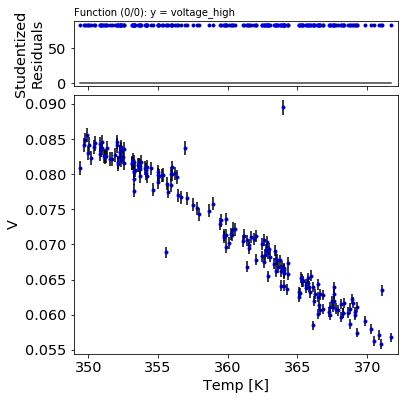

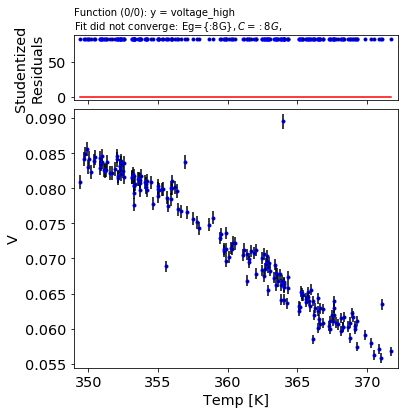

In [78]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# help(s.data.fitter)

guess='Eg=0.7, C=1e23'
# guess=' Eg=.4, C=1e23, Ch=1e23, power=1.5'

my_fitter.set_functions(f=voltage_high, p=guess)

my_fitter.set_data(xdata=TempDataComHigh[0][100:], ydata=DataComHigh[5][100:], eydata=DataCom_ErrHigh[5][100:], exdata=TempDataComHigh[1][100:])
# my_fitter.set_data(xdata=TempDataComHigh, ydata=DataComHigh[4], eydata=0.001)

my_fitter.fit()
print()